In [ ]:
!apt install fluidsynth

!git clone https://github.com/Serge-Andre-MASSON/pitch_tracker.git
!pip install /content/pitch_tracker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 34 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

As a first step, one needs to load a configuration file. Here the default conf.yaml is loaded.

Then an example wave file is loaded and its waveform is extracted.

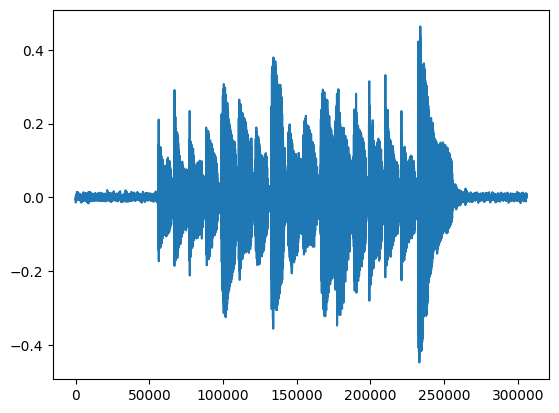

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import Audio

from pitch_tracker.config import Config
from pitch_tracker.audio_file import AudioFile


config = Config("/content/pitch_tracker/conf.yaml")

audio_file_path = Path("/content/pitch_tracker/wavs/ce_soir_a_la_brume.wav")
display(Audio(audio_file_path))

audio_file = AudioFile(
    audio_file_path,
    **config.get_audio_file_config()
)

waveform = audio_file.get_waveform()
plt.plot(waveform);


Below, waveform's features (amplitude and frequency) are extracted. With those it's possible to extract beats from a kmeans based peaks detection algorithm. It appears that extracted beats differs and this is the reason why they are extracted from both of those features : sometimes, frequency moves whereas amplitude does not (eg : a bend or a pull off).

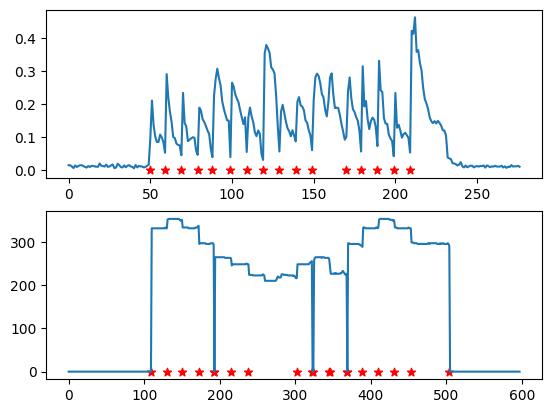

In [ ]:
import numpy as np
from pitch_tracker.waveform_features import Amplitude, Frequency
from pitch_tracker.beat import AmplitudeBeat, FrequencyBeat


amplitude = Amplitude(waveform, **config.get_amplitude_config())
amplitude_features = amplitude.get_features()

amplitude_beat = AmplitudeBeat(amplitude)
amplitude_beats = amplitude_beat.get_beats()

plt.subplot(211)
plt.plot(amplitude_features)
plt.scatter(
    amplitude_beats, 
    np.zeros_like(amplitude_beats),
    marker="*",
    c="r"
)

frequency = Frequency(waveform, **config.get_frequency_config())
frequency_features = frequency.get_features()

frequency_beat = FrequencyBeat(frequency)
frequency_beats = frequency_beat.get_beats()

plt.subplot(212)
plt.plot(frequency_features)
plt.scatter(
    frequency_beats, 
    np.zeros_like(frequency_beats), 
    marker="*", 
    c="r");

Those beats can be merged according to a proximity threshold using the Beat object.

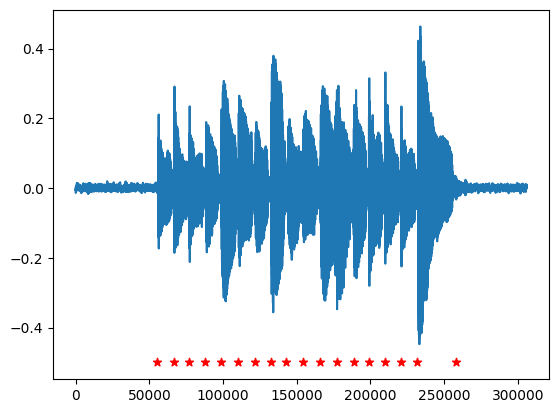

In [ ]:
from pitch_tracker.beat import Beat


beat = Beat(amplitude, frequency, **config.get_beat_config())
waveform_beats = beat.get_beats()

plt.plot(waveform)
plt.scatter(
    waveform_beats, 
    np.zeros_like(
    waveform_beats)-.5, 
    marker="*", 
    c="r"
);

From here, things needs to be improve. The main idea is to get the most likely pitches between each beats and infer the bpm from beats distribution. 
The algorithm to find the bpm is yet to be improved.

In [ ]:
from pitch_tracker.bpm import get_bpm_and_midi_ticks


beats_in_ms = waveform_beats / audio_file.sampling_rate * 1000
bpm, ticks = get_bpm_and_midi_ticks(beats_in_ms)

In [ ]:
frequency_beats = waveform_beats / waveform.size * frequency.features_length 
frequency_beats = frequency_beats.astype('int')

In [ ]:
from pitch_tracker.pitch_finder import read_notes


_, all_freq, available_pitches = read_notes()

pitches_index = [
    np.argmin(
        np.abs(all_freq - f)
    ) for f in frequency.features]

all_pitches = [int(available_pitches[index])
               if index else 0 for index in pitches_index]

In [ ]:
last_beat = frequency_beats[0]
pitches = []
for beat in frequency_beats[1:]:
    pitches_ = all_pitches[last_beat: beat]
    pitch = max(pitches_, key=lambda i: pitches_.count(i))
    if pitch:
        pitches.append(pitch)
    last_beat = beat

With bpm, ticks (duration between beats) and pitches it is easy to create a midi file that play back the raw original .wav file. 

In [ ]:
from pitch_tracker.midi import Midi


midi_conf = config.get_midi_config()

midi = Midi(bpm, guitar=24, **midi_conf)


for pitch, midi_tick in zip(pitches, ticks):
    midi.add_note(midi_tick, pitch)

In [ ]:
midi.save_wav_to("/content/tmp.wav")
Audio("/content/tmp.wav")
